In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

In [4]:

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [5]:
width = 0.03
ang = jnp.pi
num_position_grids = 15
num_angle_grids = 15
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (0.3, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)), (0.02, jnp.pi, (9,9,51)), (0.01, jnp.pi/5, (15,15,15)), (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [6]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
face_child = 3
cp_to_pose = lambda cp: table_pose@ b.scene_graph.relative_pose_from_edge(cp, face_child, b.RENDERER.model_box_dims[13])
cp_to_pose_jit = jax.jit(cp_to_pose)
cp_to_pose_parallel = jax.jit(jax.vmap(cp_to_pose, in_axes=(0,)))

key = jax.random.PRNGKey(30)


In [212]:
def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

def score_images(rendered, observed):
    mask = observed[...,2] < intrinsics.far
    return (jnp.linalg.norm(observed - rendered, axis=-1)* (1.0 * mask)).sum() / mask.sum()


# def score_images(rendered, observed):
#     return -jnp.linalg.norm(observed - rendered, axis=-1).mean()



# def score_images(rendered, observed):
#     distances = jnp.linalg.norm(observed - rendered, axis=-1)
#     width = 0.01
#     outlier_probability = 0.001
#     probabilities_per_pixel = (1.0 -  outlier_probability) * (distances < width/2) / width + outlier_probability * (1/10000.0)
#     return jnp.log(probabilities_per_pixel).sum()


In [214]:
key = jax.random.split(key,2)[0]
key = jnp.array([2755247810, 1586593754], dtype=np.uint32)
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
gt_cp = jax.random.uniform(key, shape=(3,),minval=low, maxval=high)
gt_pose = cp_to_pose_jit(gt_cp)
obs_img = b.RENDERER.render(gt_pose[None,...], jnp.array([13]))[...,:3]
# b.viz.scale_image(b.get_depth_image(obs_img[...,2]),3.0)


[43792.79  43497.336 43450.188 43235.336 43193.297 43193.297 43164.523
 43088.688 43088.688 43032.523]


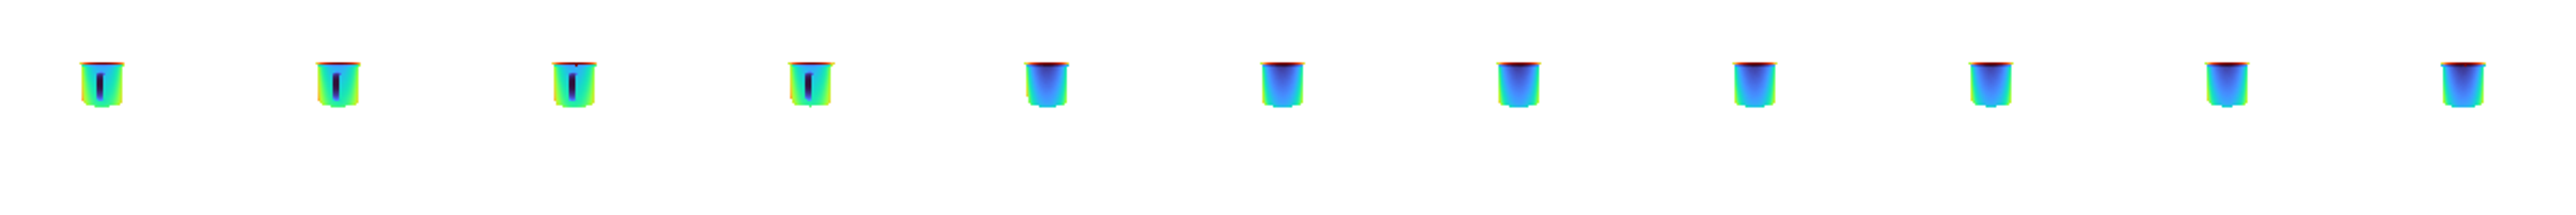

In [227]:

def score_images(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    log_probabilities_per_pixel = jax.scipy.stats.norm.logpdf(
        distances,
        loc=0.0, 
        scale=0.005
    )
    outlier_probability = 0.0001
    log_probabilities_per_pixel =  jnp.logaddexp(
        jnp.log(1.0 - outlier_probability) + log_probabilities_per_pixel,
        (jnp.log(outlier_probability) + jnp.log(1/10000.0)) * jnp.ones_like(log_probabilities_per_pixel)
    )
    return log_probabilities_per_pixel.sum()
score_vmap = jax.jit(jax.vmap(score_images, in_axes=(0, None)))

contact_param_grid = gt_cp + contact_param_deltas
scores =  jnp.concatenate([
    score_vmap(b.RENDERER.render_many(cp_to_pose_parallel(cps)[:,None,...], jnp.array([13]))[...,:3], obs_img)
    for cps in jnp.array_split(contact_param_grid, 15)
],axis=0)

sort_order = jnp.argsort(-scores)
sorted_scores = scores[sort_order]
k = 10
# print("GT CP: ", gt_cp)
# print(sorted_scores[:k])
# print(contact_param_grid[sort_order[:k]])
poses = cp_to_pose_parallel(contact_param_grid[sort_order[:k]])[:,None,...]
rendered_top_k = b.RENDERER.render_many(poses, jnp.array([13]))[...,:3]

print(sorted_scores[:k])
b.viz.scale_image(b.hstack_images([b.get_depth_image(obs_img[...,2]), *[b.get_depth_image(i[...,2]) for i in rendered_top_k]]),3.0)

In [190]:
log_probabilities_per_pixel = jnp.log(jnp.ones((100,100))* 0.2)
outlier_probability = 0.001
probabilities_per_pixel =  jnp.logaddexp(
    (1.0 - outlier_probability) + log_probabilities_per_pixel,
    (jnp.log(outlier_probability) + jnp.log(1/10000.0)) * jnp.ones_like(log_probabilities_per_pixel)
)

In [191]:
probabilities_per_pixel

Array([[-0.61043775, -0.61043775, -0.61043775, ..., -0.61043775,
        -0.61043775, -0.61043775],
       [-0.61043775, -0.61043775, -0.61043775, ..., -0.61043775,
        -0.61043775, -0.61043775],
       [-0.61043775, -0.61043775, -0.61043775, ..., -0.61043775,
        -0.61043775, -0.61043775],
       ...,
       [-0.61043775, -0.61043775, -0.61043775, ..., -0.61043775,
        -0.61043775, -0.61043775],
       [-0.61043775, -0.61043775, -0.61043775, ..., -0.61043775,
        -0.61043775, -0.61043775],
       [-0.61043775, -0.61043775, -0.61043775, ..., -0.61043775,
        -0.61043775, -0.61043775]], dtype=float32)